# Simulating the Mixed meal Model


In [14]:
using DifferentialEquations, SciMLBase, Plots, Random
using QuasiMonteCarlo
using Trapz
using MAT

# set random seed for reproducibility
Random.seed!(1234)


TaskLocalRNG()

In [27]:
include("Including.jl")

PlotMealResponse (generic function with 4 methods)

In [28]:
individual_1 = Individual(2)

# extract relevant data
BW_1 = individual_1.BW
fasting_glucose = individual_1.glc[1]
fasting_insulin = individual_1.ins[1]
G_dose = individual_1.G_dose



75000.0

In [29]:

model = EDES(fasting_glucose, fasting_insulin, G_dose, BW_1, estimated_params = ["k1","k5","k6", "k8"], timespan = (0.0, 480))

outputs = output(model)

(time = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  471.0, 472.0, 473.0, 474.0, 475.0, 476.0, 477.0, 478.0, 479.0, 480.0], glucose_gut_to_plasma_flux = [0.0, 0.009299984215056536, 0.021987168899833487, 0.03491735939115085, 0.04724346454007603, 0.05866328362640488, 0.06909535899739644, 0.07855785499540863, 0.08711333813042238, 0.09484160795958911  …  5.749113508539237e-5, 5.594986791486366e-5, 5.4456905975840195e-5, 5.30129757015675e-5, 5.161464178505676e-5, 5.0254307179084636e-5, 4.892021309619353e-5, 4.7608431551381045e-5, 4.633152307484161e-5, 4.508863006152056e-5], hepatic_glucose_flux = [0.043, 0.04297556103128725, 0.042880364115299684, 0.04270599889411504, 0.0424547176325834, 0.04213273058843207, 0.041747904191404395, 0.041308679753968326, 0.04082351223867257, 0.040300573694947314  …  0.04307112614338225, 0.043069722390686835, 0.04306834512200625, 0.04306699390279913, 0.043065668253166114, 0.0430643676478499, 0.04306309151623523, 0.04306183938133333, 0.04306061097068988,

In [30]:
model.prob.p

17-element Vector{Float64}:
     0.0105
     0.28
     0.00607
     0.000235
     0.0424
     2.2975
     1.15
     7.27
     0.0383
     0.284
     1.4
    13.2
     4.44438211792684
    12.5404266739517
     0.043
 75000.0
    76.0

In [31]:
outputs.glucose_gut_to_plasma_flux
trapz(outputs.glucose_gut_to_plasma_flux, outputs.time)

f_G = 0.005551 # conversion factor for glucose, from mg/l to mmol/l
V_G = (260/sqrt(BW_1/70))/1000 # volume of distribution of glucose
answer = ((V_G*BW_1)/f_G)*trapz(outputs.time, outputs.glucose_gut_to_plasma_flux)*0.001

#plot(outputs.time, outputs.glucose_gut_to_plasma_flux, label = "glucose_gut_to_plasma_flux")

74.99326225171568

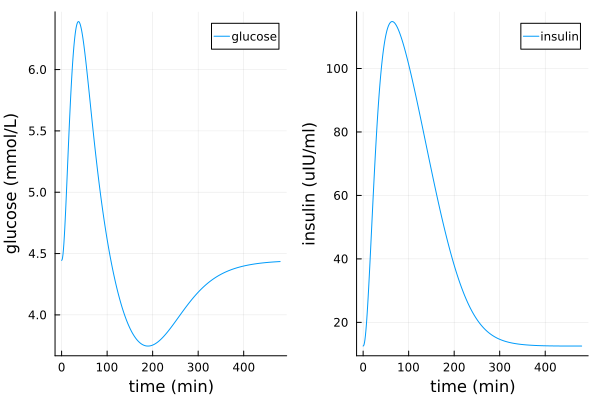

In [32]:
# four plots in a 2x2 grid showing plasma glucose, plasma insulin, plasma TG, and plasma NEFA
plot(outputs.time, [outputs.plasma_glucose, outputs.plasma_insulin], layout = (1, 2), label = ["glucose" "insulin"], xlabel = "time (min)", ylabel = ["glucose (mmol/L)" "insulin (uIU/ml)"])


# Parameter estimation with the mixed meal model

In [6]:
using Optimization, OptimizationOptimJL, LineSearches

In [7]:
# get data
data = Individual(1);
# extract relevant data
BW_1 = individual_1.BW
fasting_glucose = individual_1.glc[1]
fasting_insulin = individual_1.ins[1]
G_dose = individual_1.G_dose
println(fasting_insulin)

model = EDES(fasting_glucose, fasting_insulin, estimated_params = ["k1","k5","k6","k8"], timespan = (0.0, 480))

21.7542994608033


EDES(ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, var"#11#12"{Float64, Float64, Float64, Float64, Float64, Float64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}(ODEFunction{true, SciMLBase.AutoSpecialize, var"#11#12"{Float64, Float64, Float64, Float64, Float64, Float64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}, Nothing, Nothing}(var"#11#12"{Float64, Float64, Float64, Float64, Float64, Float64}(0.1, 9.0, 3.0, 31.0

In [8]:
loss = make_LossFunction(model, data.glc, data.time, data.ins, data.time)

#select bounds for the latin hypercube sampler
lhc_ub = [0.5, 1.5, 10., 20.]
lhc_lb = [0.0005, 0, 0, 0.] 


# create preselected samples
initial_parameter_sets = Preselection_LHS(loss, model, 100, lhc_lb, lhc_ub)
initial_parameter_sets

4×10 Matrix{Float64}:
 0.0229775  0.257742  0.0329675  …  0.212787   0.0729275   0.0179825
 0.0825     0.0225    0.0675        1.0725     0.2175      0.6525
 1.45       2.85      9.35          3.85       1.85        7.05
 2.1        9.5       4.5           3.7       10.1        17.1

First we need to make a loss function and get the best initial parameter sets using LHCS

Then we run the optimization for every parameter set:

In [9]:
optimizer = LBFGS(linesearch = BackTracking(order=3)) # cubic interpolation

objectives = []
parameters = []

opt_lb = lhc_lb
opt_ub = lhc_ub

for it in axes(initial_parameter_sets,2)
    try 
        optf = OptimizationFunction((x,p)-> loss(x), Optimization.AutoForwardDiff())
        starting_parameters = initial_parameter_sets[:,it]
        optprob = OptimizationProblem(optf, starting_parameters, lb = opt_lb, ub = opt_ub)
        sol = Optimization.solve(optprob, optimizer)

        push!(parameters, sol.u)
        push!(objectives, sol.objective)

    catch e
        throw(e)
        println("Optimization FAILED for this initial set, continuing...")
    end
end


Get a full parameter vector:

In [10]:
full_parameter_vector = make_full_parameter_vector(model, parameters[1])

outputs = output(model, full_parameter_vector);
println(full_parameter_vector)


[0.022484420031867326, 0.28, 0.00607, 0.000235, 0.022168199823669115, 3.6092710041560885, 1.15, 9.202766545202236, 0.0383, 0.284, 1.4, 13.2, 4.97828626648081, 21.7542994608033, 0.043, 75000.0, 70.0]


Finally let's plot the fitting

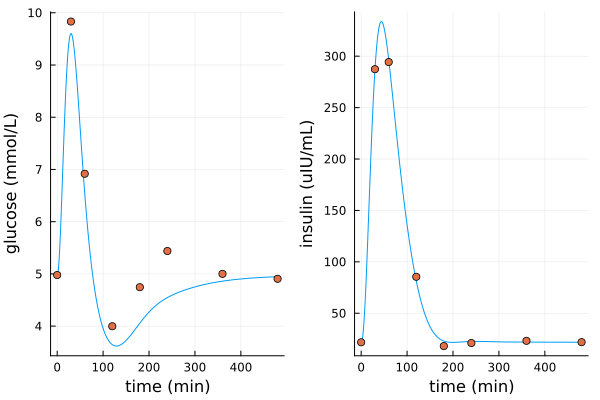

In [11]:
glucose_plot = plot(outputs.time, outputs.plasma_glucose, label = "glucose", xlabel = "time (min)", ylabel = "glucose (mmol/L)")
scatter!(data.time, data.glc, label = "glucose_data")

insulin_plot = plot(outputs.time, outputs.plasma_insulin, label = "insulin", xlabel = "time (min)", ylabel = "insulin (uIU/mL)")
scatter!(data.time, data.ins, label = "insulin_data")


plot(glucose_plot, insulin_plot, layout = (1, 2),legend=false)